# Capstone Project Code - Draft Version
### Produced by Thomas Reimer

Import relevant packages:

In [4]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
pd.set_option("display.max_rows", 320, "display.max_columns", 30)

import json # library to handle JSON files
from math import sin, cos, sqrt, atan2, radians
from geopy.geocoders import Nominatim 
import folium
import shapely.geometry
from pyproj import Transformer
import requests 
import os
import time

import matplotlib.pyplot as plt # plotting library
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


## Locations Setup

The analysis will focus on central London - let's identify the lat/long for the centre, and the corresponding address

In [5]:
london_address = 'London, UK'

geolocator = Nominatim(user_agent="london_addresses")
location = geolocator.geocode(london_address)
london_lat = location.latitude
london_lon = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(london_lat, london_lon))
address_check = geolocator.reverse([london_lat, london_lon], addressdetails=False)
print ('The centre of London is at: {}'.format(address_check))

The geograpical coordinate of London are 51.5073219, -0.1276474.
The centre of London is at: Charles I, Charing Cross, Westminster, Covent Garden, London, Greater London, England, SW1, United Kingdom


Let's make a function to measure distance (in kms) from a lat/long to central London

In [6]:
earth_radius = 6371.0

def dist_to_london_centre(latitude, longitude): #in Kms
    
    # compare lat longs with london centre, in radians
    dlat = radians(london_lat) - radians(latitude)
    dlon = radians(london_lon) - radians(longitude)
    
    # use trig to calculate distance
    a = sin(dlat / 2)**2 + cos(radians(51.5074)) * cos(radians(latitude)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = earth_radius * c

    return distance

Let's import some post code area data, which we might use for this analysis:

In [7]:
filename = os.getcwd() + '/data/postcode-outcodes.csv'
pcData = pd.read_csv(filename)

Let's filter down to the locations that we consider to be "central" London - arbitrarily 4km from the centre

In [8]:
for i in pcData.index:
    dist = dist_to_london_centre(pcData['latitude'][i],pcData['longitude'][i])

    pcData.at[i,'distanceToCentreLondon'] = dist
    pcData.at[i,'centralLondon'] = dist < 4  

pcData = pcData[pcData.centralLondon]

pcData.head()

,id,postcode,latitude,longitude,distanceToCentreLondon,centralLondon
747,749,EC1,51.52286,-0.10144,2.504771,True
748,750,EC1A,51.52019,-0.10300,2.226300,True
749,751,EC1M,51.52106,-0.10152,2.366938,True
750,752,EC1N,51.52026,-0.10732,2.012056,True
751,753,EC1R,51.52475,-0.10713,2.402318,True


We are also going to explore defining our own locations grid, which is easier to define in a standard (x, y) plane. Let's create the relevant transformers and check we are consistent when transforming from lat/long to (x, y) and back

In [9]:
transform_lltoxy = Transformer.from_crs("EPSG:4326", "EPSG:32630", always_xy=True)
transform_xytoll = Transformer.from_crs("EPSG:32630", "EPSG:4326", always_xy=True) 

print('Coordinate transformation check')
print('-------------------------------')
print('London center longitude={}, latitude={}'.format(london_lon, london_lat))
x, y = transform_lltoxy.transform(london_lon, london_lat)
print('London center X={}, Y={}'.format(x, y))
lo, la = transform_xytoll.transform(x, y)
print('London center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
London center longitude=-0.1276474, latitude=51.5073219
London center X=699327.1629885819, Y=5710155.49053811
London center longitude=-0.12764740000000097, latitude=51.5073219


We will also need to measure distances in the (x, y) space, so we create the relevant function

In [10]:
def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return sqrt(dx*dx + dy*dy)

Now, let's set up our grid of locations, which will have a radius of 500m and be equally spaced within 4km of the centre of london

In [64]:
london_x, london_y = transform_lltoxy.transform(london_lon, london_lat)

r=300
count = 25

x_step = 2*r
x_min = london_x - ((count-1)/2)*x_step

y_step = sqrt(3)*r
y_min = london_y - ((count-1)/2)*y_step

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
names = []
id = 0

for i in range(0, count):
    y = y_min + i * y_step
    x_offset = r if i%2==0 else 0
    for j in range(0, count):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(london_x, london_y, x, y)
        if (distance_from_center <= 4001):
            lon, lat = transform_xytoll.transform(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)
            
            names.append(id)
            id = id+1

hexData = pd.DataFrame(
    {'Location': names,
     'Lat': latitudes,
     'Lon': longitudes,
     'Dist_to_cent': distances_from_center,
     'x': xs,
     'y': ys
    })

hexData.head()

,Location,Lat,Lon,Dist_to_cent,x,y
0,0,51.475079,-0.146958,3830.143600,698127.162989,5.706518e+06
1,1,51.474868,-0.138329,3686.461718,698727.162989,5.706518e+06
2,2,51.474657,-0.129701,3637.306696,699327.162989,5.706518e+06
3,3,51.474446,-0.121073,3686.461718,699927.162989,5.706518e+06
4,4,51.474233,-0.112445,3830.143600,700527.162989,5.706518e+06


Now, let's plot our postcodes and our defined grid, to understand which might be more useful

In [65]:
map_lon = folium.Map(location=[london_lat, london_lon], zoom_start=14)

for lat, lng, pc in zip(pcData['latitude'], pcData['longitude'], pcData['postcode']):
    label = '{}'.format(pc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  

for lat, lng in zip(hexData['Lat'], hexData['Lon']):
    folium.Circle(
        [lat, lng],
        radius= r,
        color='red',
        fill=False).add_to(map_lon)  
    
map_lon

Clearly, the postcodes are not equally spaced and do not cover equally sized areas, which might overcomplicate our analysis and lead to unintuitive results. Let's move forward with our defined grid.

## Foursquare data prep

Let's setup our credentials and functions to leverage the Foursquare API

In [66]:
CLIENT_ID = 'MI4VMXF3ZBLYXJOWZWAGPEFQAJ1EIO3R0E0AYIHZ2VGFWPLQ' # your Foursquare ID
CLIENT_SECRET = '4BN52O23UH2Z5SFZIQMSPCDDFLBTQ1VWWADIPYV5ZQJGQ1QY' # your Foursquare Secret
VERSION = '20180605' 
LIMIT = 100

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

First, let's pull the nearby venues for each of our locations

In [67]:
local_venues = getNearbyVenues( names=hexData['Location']
                                , latitudes=hexData['Lat']
                                , longitudes=hexData['Lon']
                                , radius = r
                                  )

local_venues.head()

,Location,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,0,51.475079,-0.146958,Boqueria,51.476628,-0.148214,Spanish Restaurant
1,0,51.475079,-0.146958,The Victoria,51.472940,-0.148113,Gastropub
2,0,51.475079,-0.146958,San Gennaro,51.476276,-0.148440,Italian Restaurant
3,0,51.475079,-0.146958,Loaf,51.474204,-0.147358,Furniture / Home Store
4,0,51.475079,-0.146958,The Power Station,51.477164,-0.146417,Bar


In [68]:
local_venues.shape

(4654, 7)

Let's export the file, for future reference

In [69]:
exportfile = os.getcwd() + '/data/local_venues.csv'
local_venues.to_csv(exportfile)

Let's see how many venues were captured for each of our locations...

It appears that one location hit the cap of 100 venues, but that is fine as we are limited by how many calls we can make to the API and we will just factor this into further analysis as a caveat

In [70]:
grouped_locations = local_venues.groupby(by=['Location'], as_index = False).count().sort_values(by='Latitude')[['Location','Latitude']]
grouped_locations.columns = ['Location','Count']

grouped_locations.tail(15)

,Location,Count
143,144,62
91,92,62
92,93,65
108,109,65
154,155,66
36,37,66
100,101,68
104,105,70
68,69,70
35,36,70


Let's also plot this information, to give us a feel for the distribution

<AxesSubplot:xlabel='Location'>

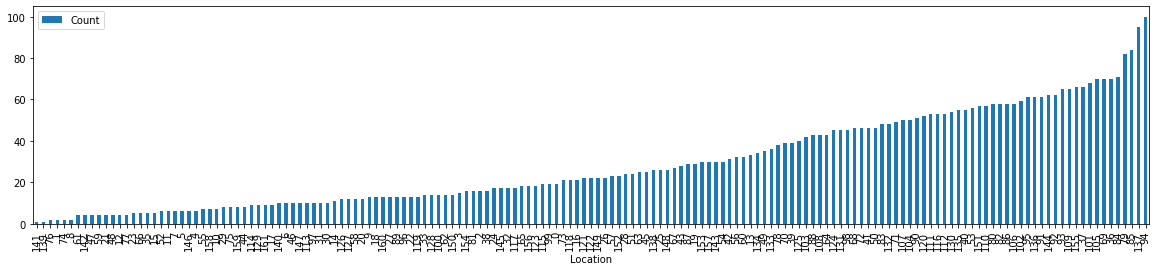

In [71]:
grouped_locations.plot(kind='bar', x='Location', y='Count', figsize=(20,4))

We are also interested in the venue categories that appear, and the frequency of these, as we may wish to clean this up a little to simplify our analysis

In [72]:
grouped_venues = local_venues.groupby(by=['VenueCategory'], as_index = False).count()[['VenueCategory','Location']]
grouped_venues.columns = ['VenueCategory','Count']

exportfile = os.getcwd() + '/data/grouped_venues.csv'
grouped_venues.to_csv(exportfile)

grouped_venues_filtered = grouped_venues[grouped_venues['Count']>10].sort_values(by='Count')

grouped_venues_filtered.shape

(92, 2)

In [73]:
grouped_venues_filtered.tail()

,VenueCategory,Count
168,Italian Restaurant,161
50,Café,211
157,Hotel,238
252,Pub,247
72,Coffee Shop,299


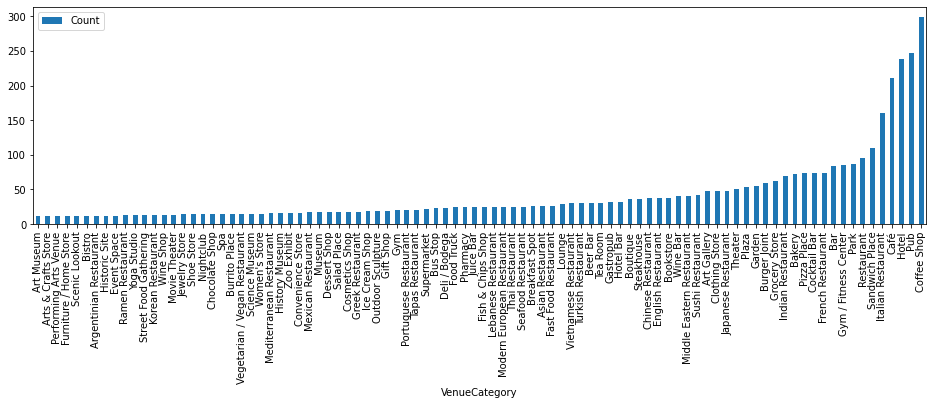

In [74]:
grouped_venues_filtered.plot(kind='bar',x='VenueCategory', y='Count', figsize=(16,4))
plt.show()

Let's simplify the categories, and focus in on those that will be most relevant to our analysis

In [75]:
# local_venues.drop(labels='NewCategory', axis=1)

local_venues['NewCategory']=""
 
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Food')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Takeaway')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Fish & Chips')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Sandwich')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Bakery')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Breakfast')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Deli')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Drink')] = 'OtherDrink'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Wine')] = 'OtherDrink'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Beer')] = 'OtherDrink'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Supermarket')] = 'Grocery'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Grocery')] = 'Grocery'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Convenience')] = 'Grocery'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Steakhouse')] = 'Restaurant'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Restaurant')] = 'Restaurant'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Bar')] = 'Bar'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Pub')] = 'Bar'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Gastropub')] = 'Bar'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Café')] = 'Cafe'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Coffee')] = 'Cafe'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Pizza')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Brasserie')] = 'Restaurant'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Burger')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Diner')] = 'OtherFood'
local_venues['NewCategory'][local_venues.VenueCategory.str.contains('Tea Room')] = 'Cafe'
 
local_venues.head()

,Location,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,VenueCategory,NewCategory
0,0,51.475079,-0.146958,Boqueria,51.476628,-0.148214,Spanish Restaurant,Restaurant
1,0,51.475079,-0.146958,The Victoria,51.472940,-0.148113,Gastropub,Bar
2,0,51.475079,-0.146958,San Gennaro,51.476276,-0.148440,Italian Restaurant,Restaurant
3,0,51.475079,-0.146958,Loaf,51.474204,-0.147358,Furniture / Home Store,
4,0,51.475079,-0.146958,The Power Station,51.477164,-0.146417,Bar,Bar


In [97]:
location_grouped_venues = local_venues.groupby(by=['Location','NewCategory'], as_index = False).count()[['Location','NewCategory','Venue']]
location_grouped_venues.columns = ['Location','NewCategory','Count']

location_grouped_venues = location_grouped_venues[location_grouped_venues['NewCategory']!=""].sort_values(by=['Location','Count'])
location_grouped_venues = location_grouped_venues.pivot(index='Location', columns='NewCategory', values='Count').fillna(0)

exportfile = os.getcwd() + '/data/location_grouped_venues.csv'
location_grouped_venues.to_csv(exportfile)

location_grouped_venues.head()

NewCategory,Bar,Cafe,Grocery,OtherDrink,OtherFood,Restaurant
Location,,,,,,
0,6.0,0.0,1.0,0.0,0.0,4.0
2,2.0,1.0,0.0,0.0,4.0,3.0
3,0.0,2.0,6.0,0.0,1.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0


In [141]:
X = pd.merge(left=hexData, right=location_grouped_venues, on='Location', how='inner')[['Location','Bar','Cafe','Restaurant','Grocery','Dist_to_cent']]
X = X.set_index('Location')

X.head()

,Bar,Cafe,Restaurant,Grocery,Dist_to_cent
Location,,,,,
0,6.0,0.0,4.0,1.0,3830.143600
2,2.0,1.0,3.0,0.0,3637.306696
3,0.0,2.0,1.0,6.0,3686.461718
4,0.0,0.0,1.0,1.0,3830.143600
5,0.0,1.0,0.0,0.0,3758.989226


In [142]:
X_scaled = pd.DataFrame(
    data = preprocessing.StandardScaler().fit(X).transform(X)
    , index = X.index
    , columns = X.columns
    )

X_scaled.head()

,Bar,Cafe,Restaurant,Grocery,Dist_to_cent
Location,,,,,
0,0.627709,-1.129412,-0.472266,0.344697,1.242967
2,-0.545017,-0.803740,-0.617865,-0.709670,1.037719
3,-1.131379,-0.478069,-0.909065,5.616532,1.090037
4,-1.131379,-1.129412,-0.909065,0.344697,1.242967
5,-1.131379,-0.803740,-1.054664,-0.709670,1.167233


We particularly care about locations with less cafes but plenty of complementary venues, so we might define an area "score" also

In [157]:
X_scaled["Score"] = X_scaled["Bar"] - 2*X_scaled["Cafe"] + X_scaled["Restaurant"] - X_scaled["Grocery"] + X_scaled["Dist_to_cent"]
X_scaled.head()

,Bar,Cafe,Restaurant,Grocery,Dist_to_cent,Score
Location,,,,,,
0,0.627709,-1.129412,-0.472266,0.344697,1.242967,3.312537
2,-0.545017,-0.803740,-0.617865,-0.709670,1.037719,2.191987
3,-1.131379,-0.478069,-0.909065,5.616532,1.090037,-5.610800
4,-1.131379,-1.129412,-0.909065,0.344697,1.242967,1.116650
5,-1.131379,-0.803740,-1.054664,-0.709670,1.167233,1.298340


In [158]:
Kmax = 10

Inertia: We talked about one metric in the previous section, which is the within-cluster sum of squares of distances to the cluster center. This is called “inertia”. The algorithm aims to choose centroids that minimize the inertia, which can be recognized as a measure of how internally coherent clusters are.

Silhouette Score: Silhouette score is based on a combination of cluster Cohesion (how close points in a cluster are relative to each other) and Separation (how far the clusters are relative to each other).


Text(0.5, 1.0, 'Silhouetter Score Curve')

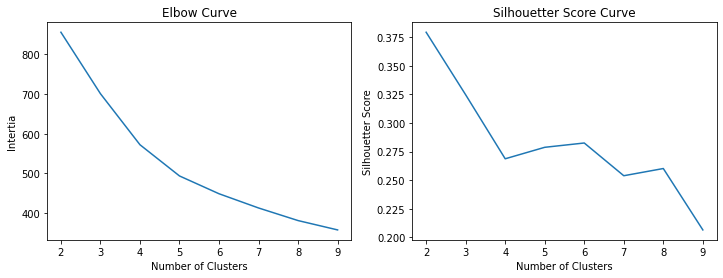

In [159]:
# Calculating the inertia and silhouette_score¶
inertia = []
sil = []

# changing the number of clusters 
for k in range(2,Kmax):
    
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X_scaled)
    y_pred = km.predict(X_scaled)
    
    inertia.append((k, km.inertia_))
    sil.append((k, metrics.silhouette_score(X_scaled, y_pred)))

fig, ax = plt.subplots(1,2, figsize=(12,4))
# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')
ax[0].set_title('Elbow Curve')
# Plotting Silhouetter Score
x_sil = [x[0] for x in sil]
y_sil  = [x[1] for x in sil]
ax[1].plot(x_sil, y_sil)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouetter Score')
ax[1].set_title('Silhouetter Score Curve')

In [160]:
for k in [2,3,6]:
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_scaled)

    # add clustering labels
    X['Cluster']= kmeans.labels_

    print(X.groupby(by='Cluster').mean())
    print('----------------')

Bar      Cafe  Restaurant   Grocery  Dist_to_cent
Cluster                                                        
0        3.028037  1.953271    5.439252  0.392523   2913.184260
1        5.673469  6.775510   11.183673  1.285714   2114.578308
----------------
              Bar      Cafe  Restaurant   Grocery  Dist_to_cent
Cluster                                                        
0        2.177778  1.455556    3.011111  0.322222   3017.137424
1        7.000000  5.825000   16.200000  0.800000   2200.312836
2        4.846154  6.807692    8.115385  1.692308   2145.006590
----------------
              Bar      Cafe  Restaurant   Grocery  Dist_to_cent
Cluster                                                        
0        1.760870  1.956522    2.891304  0.695652   2508.092555
1        4.928571  7.357143    8.071429  1.142857   1475.127691
2        2.500000  1.240000    3.180000  0.160000   3408.894134
3        7.500000  4.545455   16.863636  0.681818   2233.526661
4        4.500000  7

In [161]:
k=3

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_scaled)

# add clustering labels
X['Cluster']= kmeans.labels_

In [164]:
location_clusters_merged = pd.merge(left=hexData, right=X, on='Location', how='inner')

location_clusters_merged = pd.merge(left=location_clusters_merged, right=X_scaled, on='Location', how='inner')

location_clusters_merged = location_clusters_merged.set_index('Location')

location_clusters_merged.head()

,Lat,Lon,Dist_to_cent_x,x,y,Bar_x,Cafe_x,Restaurant_x,Grocery_x,Dist_to_cent_y,Cluster,Bar_y,Cafe_y,Restaurant_y,Grocery_y,Dist_to_cent,Score
Location,,,,,,,,,,,,,,,,,
0,51.475079,-0.146958,3830.143600,698127.162989,5.706518e+06,6.0,0.0,4.0,1.0,3830.143600,0,0.627709,-1.129412,-0.472266,0.344697,1.242967,3.312537
2,51.474657,-0.129701,3637.306696,699327.162989,5.706518e+06,2.0,1.0,3.0,0.0,3637.306696,0,-0.545017,-0.803740,-0.617865,-0.709670,1.037719,2.191987
3,51.474446,-0.121073,3686.461718,699927.162989,5.706518e+06,0.0,2.0,1.0,6.0,3686.461718,2,-1.131379,-0.478069,-0.909065,5.616532,1.090037,-5.610800
4,51.474233,-0.112445,3830.143600,700527.162989,5.706518e+06,0.0,0.0,1.0,1.0,3830.143600,0,-1.131379,-1.129412,-0.909065,0.344697,1.242967,1.116650
5,51.480060,-0.159611,3758.989226,697227.162989,5.707038e+06,0.0,1.0,0.0,0.0,3758.989226,0,-1.131379,-0.803740,-1.054664,-0.709670,1.167233,1.298340


In [165]:
map_clusters = folium.Map(location=[london_lat, london_lon], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(location_clusters_merged['Lat'], location_clusters_merged['Lon'], location_clusters_merged['Cluster']):
    label = folium.Popup('Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=r,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
    

map_clusters

Let's focus on cluster 1 locations

In [170]:
longList = location_clusters_merged[location_clusters_merged['Cluster']==1].sort_values(by='Score', ascending=False)
longList.shape

(40, 17)

In [172]:
shortList = longList[longList['Score']>1]
shortList.shape

(11, 17)